# Financial Transactions: Detecting Collusion and Anomalies

This notebook shows how KGTK can support analysis of financial transaction data

We highlight how KGTK facilitates:

1. Data ingestion by defining a simple transaction ontology
2. Transaction data visualization using force-directed graph visualization
3. Knowledge graph transformation and filtering to detect potential colluders
4. Temporal analysis by knowledge graph partitioning 
5. Transformation to external tools, such as Tableau, for additional visualization

In [48]:
import csv
import datetime
import math

from pathlib import Path

import numpy as np
import matplotlib.pyplot as ppt
import pandas as pd

from scipy import stats
from IPython.display import IFrame

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

import aaai.util as util
from aaai.iem import IEM
from aaai.util import en, drop_en
from aaai.transaction import ColorScale, OrRd, scale, sqrt_normalize, log_normalize, Account

In [2]:
# Name of the project
project_name = 'financial'

data_dir = Path('datasets/financial')
output_dir = Path('outputs/financial')

# First and last date to extract weekly data
last_date = datetime.date.fromisoformat('2004-11-05')
first_date = datetime.date.fromisoformat('2004-06-01')

# Generate GraphTool graph files. Usefull for debugging
generate_graphtools_files = False

In [3]:
# Define and/or create output subdirectories
if not output_dir.exists():
    raise f"Output directory missing: {output_dir}"
    
tmp_dir = output_dir / 'tmp'
tableau_dir = output_dir / 'tableau'
weekly_dir = output_dir / 'weekly'
tmp_dir.mkdir(exist_ok=True)
tableau_dir.mkdir(exist_ok=True)
weekly_dir.mkdir(exist_ok=True)



In [4]:
kypher_files = ['all']
ck = ConfigureKGTK(kypher_files)
ck.configure_kgtk(input_graph_path=str(output_dir),
                  output_path=str(tmp_dir),
                  project_name=project_name)

User home: /home/kyao
Current dir: /home/kyao/dev/kgtk-aaai2023
KGTK dir: /home/kyao/dev
Use-cases dir: /home/kyao/dev/use-cases


## Import data using simple transaction ontology

Iowa Election Market data in KGTK node file format

In [5]:
trade_nodes = pd.read_csv(f"{data_dir}/financial-trade_nodes.tsv.gz", sep='\t')
trade_nodes

,id,label,description,Pisa,Ptime,Passet,Pseller,Pbuyer,Pquantity,Pprice
0,QIEM_trade_10001,'trade 10001'@en,'IEM trade identifier 10001'@en,Qfinancial_transaction,^2004-06-01T13:36:13.337/15,QIEM_asset_907,QIEM_org_217,QIEM_org_224,1,0.490
1,QIEM_trade_10002,'trade 10002'@en,'IEM trade identifier 10002'@en,Qfinancial_transaction,^2004-06-01T13:36:53.637/15,QIEM_asset_907,QIEM_org_217,QIEM_org_224,1,0.490
2,QIEM_trade_10003,'trade 10003'@en,'IEM trade identifier 10003'@en,Qfinancial_transaction,^2004-06-01T13:37:30.560/15,QIEM_asset_907,QIEM_org_217,QIEM_org_224,8,0.490
3,QIEM_trade_10004,'trade 10004'@en,'IEM trade identifier 10004'@en,Qfinancial_transaction,^2004-06-01T13:38:34.147/15,QIEM_asset_907,QIEM_org_217,QIEM_org_224,7,0.490
4,QIEM_trade_10005,'trade 10005'@en,'IEM trade identifier 10005'@en,Qfinancial_transaction,^2004-06-01T13:40:43.500/15,QIEM_asset_907,QIEM_org_217,QIEM_org_224,1,0.490
...,...,...,...,...,...,...,...,...,...,...
62611,QIEM_trade_72612,'trade 72612'@en,'IEM trade identifier 72612'@en,Qfinancial_transaction,^2004-11-05T17:22:10.410/15,QIEM_asset_968,QIEM_org_40,QIEM_org_75,6,0.001
62612,QIEM_trade_72613,'trade 72613'@en,'IEM trade identifier 72613'@en,Qfinancial_transaction,^2004-11-05T17:22:21.990/15,QIEM_asset_969,QIEM_org_40,QIEM_org_75,6,0.001
62613,QIEM_trade_72614,'trade 72614'@en,'IEM trade identifier 72614'@en,Qfinancial_transaction,^2004-11-05T18:21:53.530/15,QIEM_asset_971,QIEM_org_927,QIEM_org_201,11,0.990
62614,QIEM_trade_72615,'trade 72615'@en,'IEM trade identifier 72615'@en,Qfinancial_transaction,^2004-11-05T18:22:06.903/15,QIEM_asset_971,QIEM_org_927,QIEM_org_201,9,0.990


In [6]:
org_nodes = pd.read_csv(f"{data_dir}/financial-org_nodes.tsv", sep='\t')
org_nodes

,id,label,description,alias,Pisa
0,QIEM_org_1,'Liam'@en,'Organization 1'@en,'org_1'@en,Qperson_organization
1,QIEM_org_2,'Olivia'@en,'Organization 2'@en,'org_2'@en,Qperson_organization
2,QIEM_org_3,'Noah M'@en,'Organization 3'@en,'org_3'@en,Qperson_organization
3,QIEM_org_4,'Emma'@en,'Organization 4'@en,'org_4'@en,Qperson_organization
4,QIEM_org_5,'Oliver'@en,'Organization 5'@en,'org_5'@en,Qperson_organization
...,...,...,...,...,...
1147,QIEM_org_1146,'Elliot F'@en,'Organization 1146'@en,'org_1146'@en,Qperson_organization
1148,QIEM_org_1147,'Rodrigo'@en,'Organization 1147'@en,'org_1147'@en,Qperson_organization
1149,QIEM_org_1148,'Justice F'@en,'Organization 1148'@en,'org_1148'@en,Qperson_organization
1150,QIEM_org_1149,'Sutton M'@en,'Organization 1149'@en,'org_1149'@en,Qperson_organization


In [7]:
asset_nodes = pd.read_csv(f"{data_dir}/financial-asset_nodes.tsv", sep='\t')
asset_nodes

,id,label,description,alias,Pisa
0,QIEM_asset_907,'REP04'@en,'Republican win'@en,NaN,Qasset
1,QIEM_asset_906,'DEM04'@en,'Democratic win'@en,NaN,Qasset
2,QIEM_asset_969,'DEM04_L52'@en,'Democratic win <52%'@en,NaN,Qasset
3,QIEM_asset_968,'DEM04_G52'@en,'Democratic win >=52%'@en,NaN,Qasset
4,QIEM_asset_971,'REP04_L52'@en,'Republican win <52%'@en,NaN,Qasset
5,QIEM_asset_970,'REP04_G52'@en,'Republican win >=52%'@en,NaN,Qasset


In [8]:
!kgtk normalize-nodes -i $data_dir/financial-asset_nodes.tsv / add-id --id-style wikidata -o $output_dir/asset_edges.tsv 
!kgtk normalize-nodes -i $data_dir/financial-org_nodes.tsv   / add-id --id-style wikidata -o $output_dir/org_edges.tsv 
!kgtk normalize-nodes -i $data_dir/financial-trade_nodes.tsv.gz / add-id --id-style wikidata -o $output_dir/trade_edges.tsv.gz 
!kgtk cat -i $output_dir/trade_edges.tsv.gz $output_dir/asset_edges.tsv $output_dir/org_edges.tsv -o $output_dir/all.tsv
!gzip -f $output_dir/all.tsv

In [9]:
!zcat $output_dir/all.tsv.gz | head

node1	label	node2	id
QIEM_trade_10001	label	'trade 10001'@en	QIEM_trade_10001-label-15f920
QIEM_trade_10001	description	'IEM trade identifier 10001'@en	QIEM_trade_10001-description-71f294
QIEM_trade_10001	Pisa	Qfinancial_transaction	QIEM_trade_10001-Pisa-Qfinancial_transaction
QIEM_trade_10001	Ptime	^2004-06-01T13:36:13.337/15	QIEM_trade_10001-Ptime-517bba
QIEM_trade_10001	Passet	QIEM_asset_907	QIEM_trade_10001-Passet-QIEM_asset_907
QIEM_trade_10001	Pseller	QIEM_org_217	QIEM_trade_10001-Pseller-QIEM_org_217
QIEM_trade_10001	Pbuyer	QIEM_org_224	QIEM_trade_10001-Pbuyer-QIEM_org_224
QIEM_trade_10001	Pquantity	1	QIEM_trade_10001-Pquantity-6b86b2
QIEM_trade_10001	Pprice	0.49	QIEM_trade_10001-Pprice-6fef2f

gzip: stdout: Broken pipe


In [10]:
ck.load_files_into_cache()

kgtk query --graph-cache outputs/financial/tmp/financial/temp.financial/wikidata.sqlite3.db -i "outputs/financial/all.tsv.gz" --as all  --limit 3
node1	label	node2	id
QIEM_trade_10001	label	'trade 10001'@en	QIEM_trade_10001-label-15f920
QIEM_trade_10001	description	'IEM trade identifier 10001'@en	QIEM_trade_10001-description-71f294
QIEM_trade_10001	Pisa	Qfinancial_transaction	QIEM_trade_10001-Pisa-Qfinancial_transaction


## Display transactions using force-directed visualization

In [11]:
!kgtk visualize-graph -i $data_dir/iem-transaction-edge-1.tsv -o $output_dir/iem-transaction-edge-1.html \
--node-file $data_dir/iem-transaction-node-1.tsv --node-color-column type \
--show-text above --show-blank-labels --show-edge-label


In [12]:
IFrame(src=f"{output_dir}/iem-transaction-edge-1.html", width=500, height=500)

In [13]:
!kgtk visualize-graph -i $data_dir/iem-transaction-edge-4.tsv -o $output_dir/iem-transaction-edge-4.html \
--node-file $data_dir/iem-transaction-node-4.tsv --node-color-column type \
--show-text above --show-blank-labels
IFrame(src=f"{output_dir}/iem-transaction-edge-4.html", width=700, height=600)

In [14]:
!kgtk visualize-graph -i $data_dir/iem-transaction-edge-1000.tsv -o $output_dir/iem-transaction-edge-1000.html \
--node-file $data_dir/iem-transaction-node-1000.tsv --node-color-column type \
--show-text above --show-blank-labels
IFrame(src=f"{output_dir}/iem-transaction-edge-1000.html", width=700, height=600)

# Transforming Transaction graph to Trader-Interaction Graph

Use KGTK to transform transaction graph into trader-interaction graph to summerize the data. 

A trader-interaction graph contains a node for each trader (buyer or seller), and an interaction node between pairs of traders.

### Find all traders, include both buyers and sellers

In [15]:
kypher(''' -i all --limit 5''')

,node1,label,node2,id
0,QIEM_trade_10001,label,'trade 10001'@en,QIEM_trade_10001-label-15f920
1,QIEM_trade_10001,description,'IEM trade identifier 10001'@en,QIEM_trade_10001-description-71f294
2,QIEM_trade_10001,Pisa,Qfinancial_transaction,QIEM_trade_10001-Pisa-Qfinancial_transaction
3,QIEM_trade_10001,Ptime,^2004-06-01T13:36:13.337/15,QIEM_trade_10001-Ptime-517bba
4,QIEM_trade_10001,Passet,QIEM_asset_907,QIEM_trade_10001-Passet-QIEM_asset_907


In [16]:
buyers = kypher(''' -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pbuyer]->(buyer_node),
  (trade)-[:Pseller]->(seller_node),
  (buyer_node)-[:label]->(buyer),
  (seller_node)-[:label]->(seller)'
--return '
  distinct kgtk_lqstring_text(buyer) as trader'
''')
sellers = kypher(''' -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pbuyer]->(buyer_node),
  (trade)-[:Pseller]->(seller_node),
  (buyer_node)-[:label]->(buyer),
  (seller_node)-[:label]->(seller)'
--return '
  distinct kgtk_lqstring_text(seller) as trader'
''')
names = set(sellers['trader']).union(buyers['trader'])
print('Number of traders:', len(names))

Number of traders: 1152


### Create transaction summary for each trader

Gather buy information

In [17]:
buys = kypher(''' -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pbuyer]->(buyer_node),
  (trade)-[:Pseller]->(seller_node),
  (trade)-[:Pprice]->(price),
  (trade)-[:Pquantity]->(quantity),  
  (trade)-[:Passet]->(asset_node),
  (buyer_node)-[:label]->(buyer),
  (seller_node)-[:label]->(seller),
  (asset_node)-[:label]->(asset)'
--return '
  distinct kgtk_lqstring_text(buyer) as trader,
  sum(quantity) as net,
  sum(-quantity * price) as cash,
  sum(quantity) as quantity'
''')
buys

,trader,net,cash,quantity
0,Aaron,4,-1.015,4
1,Abby,68,-31.997,68
2,Abdiel,432,-141.522,432
3,Abel,1037,-503.875,1037
4,Abigail,2,-1.016,2
...,...,...,...,...
1121,Zion,1189,-210.891,1189
1122,Zoe,20,-8.915,20
1123,Zoey,4,-2.048,4
1124,Zuri,175,-97.831,175


Gather sell information

In [18]:
sells = kypher(''' -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pbuyer]->(buyer_node),
  (trade)-[:Pseller]->(seller_node),
  (trade)-[:Pprice]->(price),
  (trade)-[:Pquantity]->(quantity),  
  (trade)-[:Passet]->(asset_node),
  (buyer_node)-[:label]->(buyer),
  (seller_node)-[:label]->(seller),
  (asset_node)-[:label]->(asset)'
--return '
  distinct kgtk_lqstring_text(seller) as trader,
  sum(-quantity) as net,
  sum(quantity * price) as cash,
  sum(quantity) as quantity'
''')
sells

,trader,net,cash,quantity
0,Aaliyah,-498,258.033,498
1,Abdiel,-261,72.800,261
2,Abel,-2061,37.081,2061
3,Abraham,-774,199.647,774
4,Ace,-47,24.777,47
...,...,...,...,...
722,Zayn,-1995,195.022,1995
723,Zayne,-700,102.855,700
724,Zelda,-2302,619.831,2302
725,Zion,-399,190.882,399


### Account summary for each trader

In [19]:
trader = pd.DataFrame(index=list(names), columns=['net', 'quantity', 'cash']).fillna(0)
temp = pd.concat([buys.set_index('trader'), sells.set_index('trader')], axis=1).fillna(0)
trader['net'] = temp['net'].sum(axis=1)
trader['quantity'] = temp['quantity'].sum(axis=1)
trader['cash'] = temp['cash'].sum(axis=1)
trader.reset_index(inplace=True)
trader.columns = ['trader'] + trader.columns.to_list()[1:]
trader

,trader,net,quantity,cash
0,Olivia,-14025.0,63523.0,2339.872
1,Aidan,56.0,56.0,-30.464
2,Astrid,3.0,103.0,-3.890
3,Catalina,-100.0,502.0,-50.323
4,Waylon,931.0,3331.0,-520.951
...,...,...,...,...
1147,Brielle,11.0,11.0,-1.977
1148,Danna,95.0,2715.0,-278.586
1149,Ariel F,224.0,1428.0,-252.797
1150,Hayden M,465.0,1051.0,-107.556


In [20]:
trader[trader['trader']=='Eden'].loc[:, ['trader', 'net', 'quantity']]

,trader,net,quantity
957,Eden,4.0,25100.0


### Generate interaction between trader pairs

In [21]:
edge_node = kypher(''' -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pbuyer]->(buyer_node),
  (trade)-[:Pseller]->(seller_node),
  (trade)-[:Pprice]->(price),
  (trade)-[:Pquantity]->(quantity),  
  (trade)-[:Passet]->(asset_node),
  (buyer_node)-[:label]->(buyer),
  (seller_node)-[:label]->(seller),
  (asset_node)-[:label]->(asset)'
--return '
  iif(buyer<seller, 
      concat(kgtk_lqstring_text(buyer), " x ", kgtk_lqstring_text(seller)),
      concat(kgtk_lqstring_text(seller), " x ", kgtk_lqstring_text(buyer))) as edge_node ,
  iif(buyer<seller, -quantity, quantity) as net,  
  quantity as quantity'
''')

edge_node

,edge_node,net,quantity
0,Arya x Beau,-1,1
1,Arya x Beau,-1,1
2,Arya x Beau,-8,8
3,Arya x Beau,-7,7
4,Arya x Beau,-1,1
...,...,...,...
62611,Gabriel x Mila,-6,6
62612,Gabriel x Mila,-6,6
62613,Bennett x Collin,-11,11
62614,Bennett x Collin,-9,9


### Compute ratio of net change in shares versus all shares

In [22]:
count = edge_node.groupby('edge_node').count()
edge_node = edge_node.groupby('edge_node').sum()
edge_node['transactions'] = count['quantity']
edge_node.reset_index(inplace=True)
edge_node['ratio'] = abs(edge_node['net']) / edge_node['quantity']
edge_node

,edge_node,net,quantity,transactions,ratio
0,Aaliyah x Abel,42,42,2,1.0
1,Aaliyah x Adrian,1,1,1,1.0
2,Aaliyah x Amir,21,21,1,1.0
3,Aaliyah x Amirah,9,9,1,1.0
4,Aaliyah x Anastasia,32,32,4,1.0
...,...,...,...,...,...
14355,Xavier x Zelda,3,3,1,1.0
14356,Zachary x Zaire,-9,9,1,1.0
14357,Zain x Zelda,5,5,1,1.0
14358,Zaire x Zander,-9,9,1,1.0


In [23]:
edge_node[edge_node['edge_node'].str.startswith('Eden x ')]

,edge_node,net,quantity,transactions,ratio
7301,Eden x Julian,1,1,1,1.000000
7302,Eden x Kyla,-4,25090,100,0.000159
7303,Eden x Layla,-1,1,1,1.000000
7304,Eden x Luciana,-1,1,1,1.000000
7305,Eden x Madelyn,1,1,1,1.000000
7306,Eden x Raegan,-1,1,1,1.000000
7307,Eden x Romeo,1,1,1,1.000000


### Focus on potential colluding trader pairs, which have small ratios

In [24]:
ratio_cutoff = 0.5
quantity_min = 400
edge_node_reduced = edge_node[edge_node['ratio'] < ratio_cutoff]
print(edge_node_reduced.shape)
edge_node_reduced = edge_node_reduced[edge_node_reduced['quantity'] > quantity_min]
edge_node_reduced

(998, 5)


,edge_node,net,quantity,transactions,ratio
213,Addilyn x Adriana,-314,1090,135,0.288073
301,Addilyn x Landon,-283,2197,295,0.128812
495,Adelyn x Landon,-493,1077,145,0.457753
518,Adelyn x Parker M,-6,526,36,0.011407
628,Adriana x Bruce,-52,494,32,0.105263
...,...,...,...,...,...
13808,Parker M x Rosalie,-225,517,6,0.435203
13874,Peyton x Ryan M,410,1168,41,0.351027
13882,Peyton x Sean,46,482,23,0.095436
13896,Peyton x Wade,189,443,26,0.426637


In [25]:
names_reduced = list(set().union(*edge_node_reduced['edge_node'].str.split(' x ').apply(set).tolist()))
trader_reduced = trader[trader['trader'].isin(names_reduced)]
trader_reduced

,trader,net,quantity,cash
0,Olivia,-14025.0,63523.0,2339.872
4,Waylon,931.0,3331.0,-520.951
28,Sean,476.0,12378.0,-494.956
31,Destiny,-12.0,5076.0,101.785
39,Quentin,-411.0,3235.0,33.505
...,...,...,...,...
1078,Delaney,402.0,12368.0,-5.153
1118,Blakely,-5305.0,8553.0,2655.981
1124,Tristan,422.0,5920.0,-413.513
1133,Addilyn,-308.0,10502.0,-40.564


In [26]:
color_scale = ColorScale(OrRd, reverse=True)
def generate_node_file(trader_nodes, edge_nodes):

    trader_nodes['ratio'] = abs(trader_nodes['net']) / trader_nodes['quantity']
    trader_nodes['color'] = '#1d52c4'
    trader_nodes['size'] = scale(sqrt_normalize(trader_nodes['quantity']), min_value=1, max_value=10)
        
    edge_nodes['cash'] = 0
    edge_nodes.loc[:, 'color'] = color_scale.interp(edge_nodes['ratio'])
    edge_nodes['size'] = scale(sqrt_normalize(edge_nodes['quantity']), min_value=1, max_value=10)
    
    graph_nodes = []
    graph_edges = []
    for row in trader_nodes.to_dict('records'):
        node = {
            'id' : row['trader'],
            'label' : "'" + row["trader"] + "'@en",
            'type' : 'org',
            'quantity' : row['quantity'],
            'cash' : row['cash'],
            'net' : row['net'],
            'ratio' : row['ratio'],
            'color' : row['color'],
            'size' : row['size'],
            'tooltip' : f'Person: {row["trader"]}</br>Quantity: {row["quantity"]}</br>Cash: {row["cash"]}'
        }
        graph_nodes.append(node)
    for row in edge_nodes.to_dict('records'):
        node = {
            'id' : row['edge_node'],
            'label' : "",
            'type' : 'edge_node',
            'quantity' : row['quantity'],
            'cash' : row['cash'],
            'net' : row['net'],
            'ratio' : row['ratio'],
            'color' : row['color'],
            'size' : row['size'],
            'tooltip' : f'Person: {row["edge_node"]}</br>Quantity: {row["quantity"]}</br>Ratio: {row["ratio"]}'
        }
        graph_nodes.append(node)
        traders = row['edge_node'].split(' x ')
        graph_edges.append({
            'node1': traders[0],
            'label': 'link',
            'node2': row['edge_node'],
            'ratio': row['ratio'],
            'color': '#888888'
        })
        graph_edges.append({
            'node1': row['edge_node'],
            'label': 'link',
            'node2': traders[1],
            'ratio': row['ratio'],
            'color': '#888888'
        })
    return pd.DataFrame(graph_nodes), pd.DataFrame(graph_edges)


In [27]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


In [28]:
trader_transaction_graph_nodes, trader_transaction_graph_edges = generate_node_file(trader_reduced, edge_node_reduced)
trader_transaction_graph_nodes

,id,label,type,quantity,cash,net,ratio,color,size,tooltip
0,Olivia,'Olivia'@en,org,63523.0,2339.872,-14025.0,0.220786,#1d52c4,5.705805,Person: Olivia</br>Quantity: 63523.0</br>Cash:...
1,Waylon,'Waylon'@en,org,3331.0,-520.951,931.0,0.279496,#1d52c4,1.919619,Person: Waylon</br>Quantity: 3331.0</br>Cash: ...
2,Sean,'Sean'@en,org,12378.0,-494.956,476.0,0.038455,#1d52c4,3.011709,Person: Sean</br>Quantity: 12378.0</br>Cash: -...
3,Destiny,'Destiny'@en,org,5076.0,101.785,-12.0,0.002364,#1d52c4,2.209614,Person: Destiny</br>Quantity: 5076.0</br>Cash:...
4,Quentin,'Quentin'@en,org,3235.0,33.505,-411.0,0.127048,#1d52c4,1.900961,Person: Quentin</br>Quantity: 3235.0</br>Cash:...
...,...,...,...,...,...,...,...,...,...,...
236,Parker M x Rosalie,,edge_node,517.0,0.000,-225.0,0.435203,#f57850,1.592600,Person: Parker M x Rosalie</br>Quantity: 517</...
237,Peyton x Ryan M,,edge_node,1168.0,0.000,410.0,0.351027,#ea5a40,2.577265,Person: Peyton x Ryan M</br>Quantity: 1168</br...
238,Peyton x Sean,,edge_node,482.0,0.000,46.0,0.095436,#a60000,1.486112,Person: Peyton x Sean</br>Quantity: 482</br>Ra...
239,Peyton x Wade,,edge_node,443.0,0.000,189.0,0.426637,#f4754f,1.329099,Person: Peyton x Wade</br>Quantity: 443</br>Ra...


In [29]:
trader_transaction_graph_edges

,node1,label,node2,ratio,color
0,Addilyn,link,Addilyn x Adriana,0.288073,#888888
1,Addilyn x Adriana,link,Adriana,0.288073,#888888
2,Addilyn,link,Addilyn x Landon,0.128812,#888888
3,Addilyn x Landon,link,Landon,0.128812,#888888
4,Adelyn,link,Adelyn x Landon,0.457753,#888888
...,...,...,...,...,...
275,Peyton x Sean,link,Sean,0.095436,#888888
276,Peyton,link,Peyton x Wade,0.426637,#888888
277,Peyton x Wade,link,Wade,0.426637,#888888
278,Peyton,link,Peyton x Xander,0.226415,#888888


In [30]:
trader_transaction_graph_nodes.to_csv(f'{output_dir}/trader-interaction-nodes.tsv', index=False, sep='\t')
trader_transaction_graph_edges.to_csv(f'{output_dir}/trader-interaction-edges.tsv', index=False, sep='\t')

In [31]:
!kgtk visualize-graph \
  -o $output_dir/trader-interaction.html \
  -i $output_dir/trader-interaction-edges.tsv \
  --node-file $output_dir/trader-interaction-nodes.tsv --node-size-column size --node-color-column color \
  --node-color-hex --node-size-maximum 10 --node-size-minimum 1 --node-size-default 1 --tooltip-column tooltip \
  --edge-color-column color --edge-color-hex --show-text above --show-blank-labels


In [32]:
IFrame(src=f"{output_dir}/trader-interaction.html", width=1000, height=800)

## Temporal Analysis: Partition transaction graph into weekly transaction graphs

In [33]:
label_df = kypher('''
-i all
--match '(n1)-[:label]->(n2)'
--return 'n1 as node1, "label" as label, kgtk_lqstring_text(n2) as node2' ''')

dates = []
curr_date = last_date
while (curr_date > first_date):
    dates.append(curr_date)
    curr_date = curr_date - datetime.timedelta(days=7)
dates.reverse()

query_pattern = '''
-i all
--match '
  (r)-[q:Ptime]->(date), 
  (r)-[l2]->(n2)'
--where 'date >= "^%sT00:00:00/12" and date < "^%sT23:59:59/12"'
'''

claim_only_pattern2 = '''
-i all
--match '
  (n1)-[r:Pisa]->(n2)'
--where 'not n2 = "Qfinancial_transaction"'
'''

label_command = '''
-i all
--match '
  (n1)-[:Pisa]->(n2),
  (n1)-[r:label]->(l)'
--where 'not n2 = "Qfinancial_transaction"'
--return 'r.id, n1, "label" as 'label', l'
'''

def fold(df):
    qual_columns = df.columns[np.logical_not(df.columns.str.endswith('.1'))]
    claims_columns = df.columns[df.columns.str.endswith('.1')]
    quals = df.loc[:, qual_columns]
    quals = quals.drop_duplicates()
    claims = df.loc[:, claims_columns]
    claims.columns = quals.columns
    return pd.concat([claims, quals], ignore_index=True)

def get_labels(df):
    all = set(df['node1']).union(set(df['node2'])).union(set(df['label']))
    nps = []
    for x in all:
        if x.startswith('^') or x.startswith("'") or x[0] in '0123456789':
            continue
        nps.append(x)
    return label_df[label_df['node1'].isin(nps)]

def query_by_dates(begin, end):
    # columns = ['id', 'node1', 'label', 'node2', 'lang', 'rank', 'node2;wikidatatype']
    columns = ['id', 'node1', 'label', 'node2']
    query_command = query_pattern % (begin, end)
    claim_only_command = claim_only_pattern2
    # print(query_command)
    # print(claim_only_command)
    result = kypher(query_command)
    claims_with_qual = fold(result)
    claims_with_qual = claims_with_qual.loc[:, columns]
    claims_only = kypher(claim_only_command)
    claims_only = claims_only.loc[: , columns]
    labels = get_labels(claims_only)
    result = pd.concat([claims_only, claims_with_qual, labels], ignore_index=True)    
    return result

def generate_weekly(dates):
    # columns = ['id', 'node1', 'label', 'node2', 'lang', 'rank', 'node2;wikidatatype']
    # columns = ['id', 'node1', 'label', 'node2']
    for week, (begin, end) in enumerate(zip(dates, dates[1:])):
        print(begin, end)
        weekly = query_by_dates(begin, end)
        # query_command = query_pattern % (begin, end)
        # claim_only_command = claim_only_pattern2
        # result = kypher(query_command)
        # claims_with_qual = fold(result)
        # claims_with_qual = claims_with_qual.loc[:, columns]
        # claims_only = kypher(claim_only_command)
        # claims_only = claims_only.loc[: , columns]
        # labels = get_labels(claims_only)
        # weekly = pd.concat([claims_only, claims_with_qual, labels], ignore_index=True)
        outpath = f'weekly.{week}.{end}.tsv.gz'
        weekly.to_csv(weekly_dir / outpath, sep='\t', index=False)
    return weekly

### Generate weekly transaction files

In [34]:
%%time
generate_weekly(dates)

2004-06-04 2004-06-11
2004-06-11 2004-06-18
2004-06-18 2004-06-25
2004-06-25 2004-07-02
2004-07-02 2004-07-09
2004-07-09 2004-07-16
2004-07-16 2004-07-23
2004-07-23 2004-07-30
2004-07-30 2004-08-06
2004-08-06 2004-08-13
2004-08-13 2004-08-20
2004-08-20 2004-08-27
2004-08-27 2004-09-03
2004-09-03 2004-09-10
2004-09-10 2004-09-17
2004-09-17 2004-09-24
2004-09-24 2004-10-01
2004-10-01 2004-10-08
2004-10-08 2004-10-15
2004-10-15 2004-10-22
2004-10-22 2004-10-29
2004-10-29 2004-11-05
CPU times: user 27.8 s, sys: 5.49 s, total: 33.3 s
Wall time: 2min 14s


,id,node1,label,node2
0,QIEM_asset_907-Pisa-Qasset,QIEM_asset_907,Pisa,Qasset
1,QIEM_asset_906-Pisa-Qasset,QIEM_asset_906,Pisa,Qasset
2,QIEM_asset_969-Pisa-Qasset,QIEM_asset_969,Pisa,Qasset
3,QIEM_asset_968-Pisa-Qasset,QIEM_asset_968,Pisa,Qasset
4,QIEM_asset_971-Pisa-Qasset,QIEM_asset_971,Pisa,Qasset
...,...,...,...,...
146601,NaN,QIEM_org_1146,label,Elliot F
146602,NaN,QIEM_org_1147,label,Rodrigo
146603,NaN,QIEM_org_1148,label,Justice F
146604,NaN,QIEM_org_1149,label,Sutton M


### Compute PageRank for each weekly graph

In [35]:
%%time
run_graph_stat = False
if run_graph_stat:
    for infile in weekly_dir.glob('weekly.*.tsv.gz'):
        outfile = weekly_dir / f'weekly-stat.{".".join(infile.name.split(".")[1:])}'
        print(outfile)
        kgtk(f'graph-statistics -i {infile} -o {outfile}' )
    outfile

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


### Gather statistics of trader PageRank

In [36]:
%%time
weekly_pagerank_top10 = []
for week in range(22):
    statfile = next(weekly_dir.glob(f'weekly-stat.{week}.*.tsv.gz'))

    top10 = kypher(f'''
-i {statfile} -i all
--match '
  (org)-[:vertex_pagerank]->(rank),
  all: (org)-[:label]->(name),
  all: (org)-[:Pisa]->(:Qperson_organization)'
--order-by 'kgtk_quantity_number(rank) desc'
--return 'kgtk_lqstring_text(name) as trader, rank as pagerank'
--limit 10
''')
    weekly_pagerank_top10.append(top10)
weekly_pagerank_top10[-1]

CPU times: user 118 ms, sys: 174 ms, total: 292 ms
Wall time: 40.9 s


,trader,pagerank
0,Landon,0.005390
1,Adriana,0.002880
2,Kaleb,0.001645
3,Mila,0.001136
4,Elle,0.000638
5,Juan,0.000526
6,Addilyn,0.000479
7,Parker M,0.000476
8,Carter F,0.000453
9,Ryan M,0.000382


In [37]:
%%time
weekly_pagerank_sum = []
for week in range(22):
    statfile = next(weekly_dir.glob(f'weekly-stat.{week}.*.tsv.gz'))
    sum = kypher(f'''
-i {statfile} -i all
--match '
  (org)-[:vertex_pagerank]->(rank),
  all: (org)-[:Pisa]->(:Qperson_organization)'
--return '
  sum(kgtk_quantity_number(rank)) as pagerank_traders_total'
''')
    weekly_pagerank_sum.append(sum)
pagerank_weekly = pd.concat(weekly_pagerank_sum, ignore_index=True)
pagerank_weekly

top10_sum = [x['pagerank'].sum() for x in weekly_pagerank_top10]
pagerank_weekly['pagerank_traders_top10'] = top10_sum
pagerank_weekly

CPU times: user 121 ms, sys: 159 ms, total: 281 ms
Wall time: 38.8 s


,pagerank_traders_total,pagerank_traders_top10
0,0.245882,0.007179
1,0.230165,0.007987
2,0.254625,0.007504
3,0.236431,0.009158
4,0.203548,0.010246
5,0.202577,0.009794
6,0.230269,0.007979
7,0.183156,0.010310
8,0.153339,0.010362
9,0.155201,0.010948


#### Plot PageRank sum of all traders and PageRank sum of top 10 traders

<AxesSubplot: xlabel='week', ylabel='pagerank'>

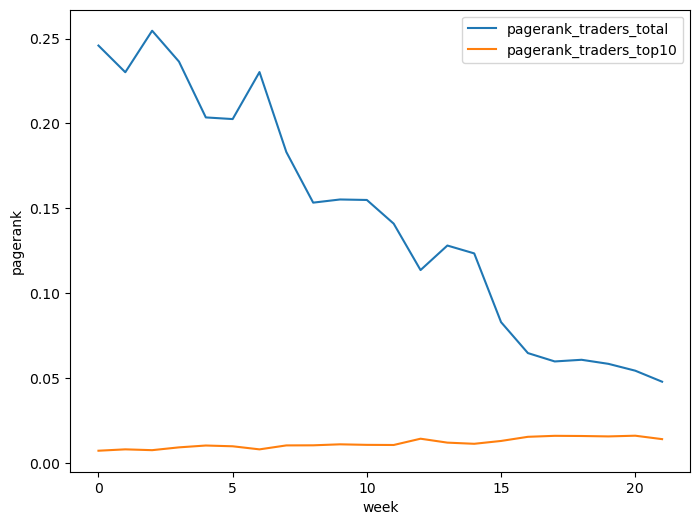

In [38]:
pagerank_weekly.plot(figsize=(8,6), xlabel='week', ylabel='pagerank')

#### Plot of PageRank ratio between top 10 and rest
#### Shows top 10 traders dominating the latter part makert 

<AxesSubplot: xlabel='week', ylabel='pagerank ratio'>

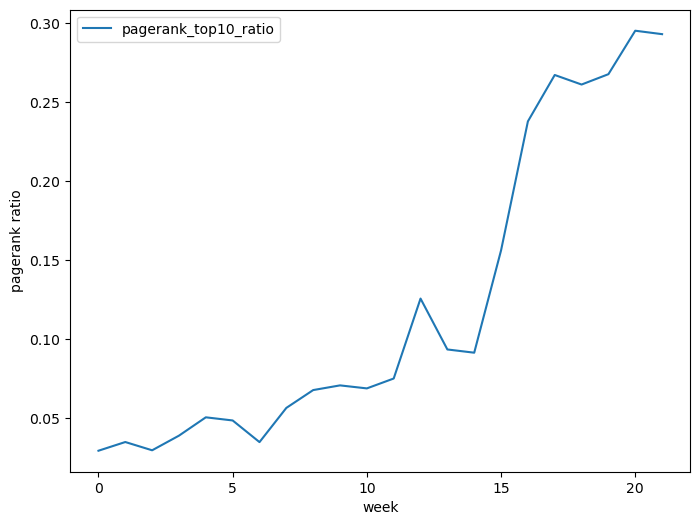

In [39]:
ratio = pd.DataFrame({'pagerank_top10_ratio' : pagerank_weekly['pagerank_traders_top10'] / pagerank_weekly['pagerank_traders_total']})
ratio.plot(figsize=(8,6), xlabel='week', ylabel='pagerank ratio')

### Compare PageRank of Assets and the prices of the assets

In [40]:
%%time
asset_pagerank_top10 = []
for week in range(22):
    statfile = next(weekly_dir.glob(f'weekly-stat.{week}.*.tsv.gz'))

    top10 = kypher(f'''
-i {statfile} -i all
--match '
  (asset)-[:vertex_pagerank]->(rank),
  all: (asset)-[:label]->(name),
  all: (asset)-[:Pisa]->(:Qasset)'
--order-by 'kgtk_quantity_number(rank) desc'
--return 'kgtk_lqstring_text(name) as asset, rank as pagerank'
--limit 10
''')
    top10 = top10.transpose()
    top10.rename(columns=top10.iloc[0,:], inplace=True)
    top10.drop(top10.index[0], inplace=True)
    asset_pagerank_top10.append(top10)
asset_pagerank_top10[-1]


CPU times: user 185 ms, sys: 156 ms, total: 341 ms
Wall time: 41.8 s


,REP04_G52,REP04_L52,DEM04_L52,DEM04_G52,REP04,DEM04
pagerank,0.004551,0.004542,0.003801,0.003434,0.000013,0.000013


In [41]:
asset_pagerank = pd.concat(asset_pagerank_top10, ignore_index=True)
asset_pagerank

,DEM04,REP04,DEM04_L52,DEM04_G52,REP04_L52,REP04_G52
0,0.003041,0.002414,0.000205,0.000205,0.000205,0.000205
1,0.003203,0.003058,0.00019,0.00019,0.00019,0.00019
2,0.002982,0.002113,0.000213,0.000213,0.000213,0.000213
3,0.003194,0.003112,0.000195,0.000195,0.000195,0.000195
4,0.003794,0.004058,0.000164,0.000164,0.000164,0.000164
5,0.004269,0.003952,0.000162,0.000162,0.000162,0.000162
6,0.003248,0.003183,0.000189,0.000189,0.000189,0.000189
7,0.004409,0.004641,0.000144,0.000144,0.000144,0.000144
8,0.005112,0.005523,0.000115,0.000115,0.000115,0.000115
9,0.005469,0.005081,0.000117,0.000117,0.000117,0.000117


In [42]:
%%time
weekly_asset_price = []
for week in range(22):
    statfile = next(weekly_dir.glob(f'weekly-stat.{week}.*.tsv.gz'))
    prices = kypher(f'''
-i {statfile} -i all
--match '
  (trade)-[:Pisa]->(:Qfinancial_transaction),
  (trade)-[:Pprice]->(price),
  (trade)-[:Passet]->(asset),  
  all: (asset)-[:label]->(name)'
--return '
  name as asset, avg(kgtk_quantity_number(price)) as price'
--limit 10
''')
    weekly_asset_price.append(prices)
weekly_asset_price[-1]
results= []
for weekly in weekly_asset_price:
    weekly['asset'] = weekly['asset'].apply(drop_en)
    results.append(weekly.set_index('asset').transpose())
results[-1]
weekly_asset_price_df = pd.concat(results, ignore_index=True)
weekly_asset_price_df.index.name = 'week'
weekly_asset_price_df.columns.name = 'asset'
weekly_asset_price_df

CPU times: user 155 ms, sys: 189 ms, total: 344 ms
Wall time: 45.3 s


asset,DEM04,REP04,DEM04_G52,DEM04_L52,REP04_G52,REP04_L52
week,,,,,,
0,0.536135,0.552646,NaN,NaN,NaN,NaN
1,0.540503,0.530494,NaN,NaN,NaN,NaN
2,0.463765,0.541152,NaN,NaN,NaN,NaN
3,0.459884,0.549057,NaN,NaN,NaN,NaN
4,0.492218,0.520118,NaN,NaN,NaN,NaN
5,0.496977,0.507967,NaN,NaN,NaN,NaN
6,0.496211,0.510591,NaN,NaN,NaN,NaN
7,0.500659,0.506571,NaN,NaN,NaN,NaN
8,0.485207,0.519745,NaN,NaN,NaN,NaN


In [43]:
asset_color = {
    'DEM04': '#00052b', 'REP04': '#400002', 
    'DEM04_L52': '#1527cf', 'DEM04_G52': '#040f70',
    'REP04_L52': '#f0181f', 'REP04_G52': '#800408'
}

#### Asset prices show REP_L52 winning towards the end

<AxesSubplot: xlabel='week', ylabel='price'>

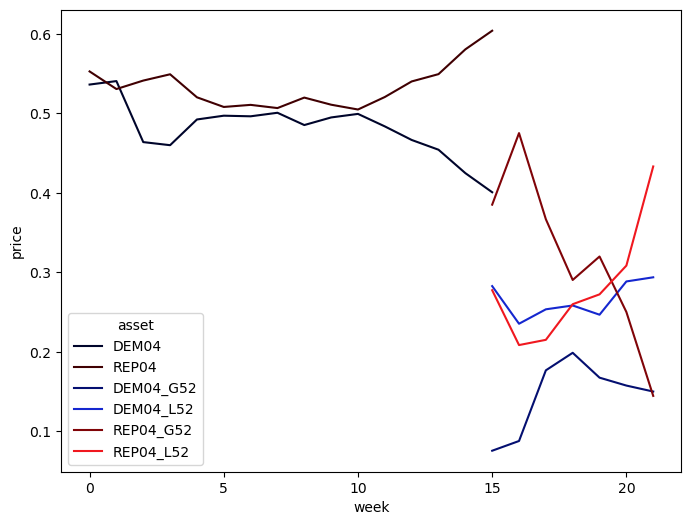

In [44]:
weekly_asset_price_df.plot(figsize=(8,6), ylabel='price', color=asset_color)

#### PageRank shows it is competition between REP04_L52 and REP_G52

<AxesSubplot: xlabel='week', ylabel='pagerank'>

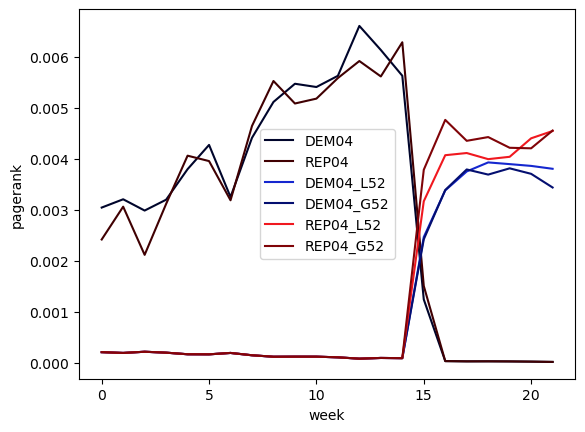

In [45]:
asset_pagerank.plot(ylabel='pagerank', xlabel='week', color=asset_color)

## Generate CSV files for Tableau visualization

In [49]:
trades_tableau = kypher(f''' -i all
--match '
(txn)-[:Pisa]->(:Qfinancial_transaction),
(txn)-[:Pbuyer]->(qbuyer),
(txn)-[:Pseller]->(qseller),
(txn)-[:Ptime]->(time),
(txn)-[:Pprice]->(price),
(txn)-[:Passet]->(qasset),
(txn)-[:Pquantity]->(quantity),
(txn)-[:label]->(ltxn),
(qbuyer)-[:label]->(buyer),
(qseller)-[:label]->(seller),
(qasset)-[:label]->(asset)'
--return 'kgtk_lqstring_text(ltxn) as transaction, kgtk_lqstring_text(buyer) as buyer, kgtk_lqstring_text(seller) as seller,
time as time, kgtk_lqstring_text(asset) as asset, price as price, quantity as quantity'
''')
trades_tableau['time'] = trades_tableau['time'].apply(util.to_date)
trades_tableau

,transaction,buyer,seller,time,asset,price,quantity
0,trade 10001,Arya,Beau,2004-06-01T13:36:13.337,REP04,0.490,1
1,trade 10002,Arya,Beau,2004-06-01T13:36:53.637,REP04,0.490,1
2,trade 10003,Arya,Beau,2004-06-01T13:37:30.560,REP04,0.490,8
3,trade 10004,Arya,Beau,2004-06-01T13:38:34.147,REP04,0.490,7
4,trade 10005,Arya,Beau,2004-06-01T13:40:43.500,REP04,0.490,1
...,...,...,...,...,...,...,...
62611,trade 72612,Gabriel,Mila,2004-11-05T17:22:10.410,DEM04_G52,0.001,6
62612,trade 72613,Gabriel,Mila,2004-11-05T17:22:21.990,DEM04_L52,0.001,6
62613,trade 72614,Bennett,Collin,2004-11-05T18:21:53.530,REP04_L52,0.990,11
62614,trade 72615,Bennett,Collin,2004-11-05T18:22:06.903,REP04_L52,0.990,9


In [50]:
buyer_tableau = pd.DataFrame({'buyer': list(names)})
seller_tableau = pd.DataFrame({'seller': list(names)})

In [51]:
ratio = edge_node.loc[:, ['net', 'quantity', 'transactions', 'ratio']]
ratio['net'] = abs(ratio['net'])
ratio['buyer'] = edge_node.loc[:, 'edge_node'].apply(lambda x: x.split(' x ')[0])
ratio['seller'] = edge_node.loc[:, 'edge_node'].apply(lambda x: x.split(' x ')[1])
ratio

,net,quantity,transactions,ratio,buyer,seller
0,42,42,2,1.0,Aaliyah,Abel
1,1,1,1,1.0,Aaliyah,Adrian
2,21,21,1,1.0,Aaliyah,Amir
3,9,9,1,1.0,Aaliyah,Amirah
4,32,32,4,1.0,Aaliyah,Anastasia
...,...,...,...,...,...,...
14355,3,3,1,1.0,Xavier,Zelda
14356,9,9,1,1.0,Zachary,Zaire
14357,5,5,1,1.0,Zain,Zelda
14358,9,9,1,1.0,Zaire,Zander


In [52]:
%%time
assets = ['REP04', 'DEM04', 'REP04_L52', 'REP04_G52', 'DEM04_L52', 'DEM04_G52']
accounts = dict()
for i, row in trades_tableau.iterrows():
    if i % 10000 == 0:
        print(i)
    if row['buyer'] not in accounts:
        buyer = Account(row['buyer'], assets)
        accounts[row['buyer']] = buyer
    else:
        buyer = accounts[row['buyer']]
    if row['seller'] not in accounts:
        seller = Account(row['seller'], assets)
        accounts[row['seller']] = seller
    else:
        seller = accounts[row['seller']]
    buyer.buy(row['asset'], row['quantity'], row['price'])
    seller.sell(row['asset'], row['quantity'], row['price'])

0
10000
20000
30000
40000
50000
60000
CPU times: user 5.66 s, sys: 0 ns, total: 5.66 s
Wall time: 5.65 s


In [53]:
rows = []
for acc in accounts.values():
    row = acc.portfolio.copy()
    row['id'] = acc.org
    row['cash'] = acc.cash
    row['final_value'] = acc.cash  + acc.portfolio['REP04_L52']
    rows.append(row)
quantity = pd.DataFrame(rows, columns=['id', 'final_value', 'cash'] + ['REP04', 'DEM04', 'REP04_L52', 'REP04_G52', 'DEM04_L52', 'DEM04_G52'])
quantity.sort_values('final_value', ascending=False, inplace=True)

In [54]:
buyer_tableau.to_csv(f'{tableau_dir}/buyer.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)
seller_tableau.to_csv(f'{tableau_dir}/seller.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)
ratio.to_csv(f'{tableau_dir}/ratio.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)
quantity.to_csv(f'{tableau_dir}/quantity.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)
trades_tableau.to_csv(f'{tableau_dir}/transaction.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)